In [1]:
### Import data & libraries
import numpy as np
import pandas as pd
import seaborn as sns
import ipystata
import mysql.connector
from sqlalchemy import create_engine
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Establish connection
connection = mysql.connector.connect(
    host='localhost',       # e.g., 'localhost'
    user='root',   # e.g., 'root'
    password='Taichi!993',
    database='varhs'
)

query = "SELECT * FROM agri_production"
df = pd.read_sql(query, connection)
print(df.head())

# Close the connection
connection.close()

C:\Users\USER\AppData\Local\Temp\ipykernel_8320\1035671170.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


   tinh_2016  quan_2016  xa_2016  ma_h0_2016 p5ma_ p15q1_  p15q2_ p15q3a_  \
0        105          3       21          15    a8      1     100     264   
1        105          3       21          15    a2      5     100    1000   
2        105          3       21          15    a5      1     100     200   
3        105          5       53           1    a6     19      80      98   
4        105          5       53           1    a5      1     100     300   

  p15q3b_ p15q4_  ... p8q8_ p8q9_ p8q10_ p9q2_ p9q8_ p12q1_ p12q2a_ p12q2b_  \
0       1      1  ...   2.0     2   15.0   NaN   NaN    2.0                   
1       1      2  ...   2.0     2    3.0   NaN   NaN    2.0                   
2       1      1  ...   2.0     2   15.0   NaN   NaN    2.0                   
3       1      2  ...   2.0     2    0.0   NaN   NaN    1.0       6       0   
4       1      1  ...   2.0     2    5.0   NaN   NaN    2.0                   

   p13aq1_  organic_fertilizer  
0        2               800.

In [3]:
#### Data Wrangling
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Rename columns
    df = df.rename(columns={'p5ma_':'plot_code',
                     'p15q1_':'crop_season_1',
                     'p15q2_':'percent_area_season_1',
                     'p15q3a_':'crop_quantity_season_1',
                     'p15q3b_':'crop_unit_1',
                     'p15q4_':'crop_reason_1',
                     'p15q5_':'crop_season_2',
                     'p15q6_':'percent_area_season_2',
                     'p15q7a_':'crop_quantity_season_2',
                     'p15q7b_':'crop_unit_2',
                     'p15q8_':'crop_season_3',
                     'p15q9_':'percent_area_season_3',
                     'p15q10a_':'crop_quantity_season_3',
                     'p15q10b_':'crop_unit_3',
                     'p5q1_':'distance',
                     'p5q3a_':'total_area',
                     'p5q7_':'land_type',
                     'p6q9_':'problems',
                     'p6q10_':'plot_quality_village',
                     'p6q10b_':'plot_quality_last_3_years',
                     'p6q11_':'irrigation',
                     'p6q12_':'water_source',
                     'p7q15a_':'conservation_infrastructure_1',
                     'p7q15b_':'conservation_infrastructure_2',
                     'p8q1_':'manager_owned_plot',
                     'p8q2a_':'red_book',
                     'p8q2b_':'why_no_red_book',
                     'p8q8_':'obtain_mortgage',
                     'p8q9_':'could_obtain_mortgate',
                     'p8q10_':'fallow_owned_plot',
                     'p9q2_':'manager_rented_plot',
                     'p9q8_':'fallow_rented_plot',
                     'p12q1':'land_investment',
                     'p12q2_a':'invest_type_1',
                     'p12q2_b':'invest_type_2',
                     'p13qa1_':'natural_disaster'})
    #Create a new variable to identify plots that grew coffee as the main crop in 
    #at least one season in 2016 (Coffee's code = 11)
    df['Coffee_plot'] = 0
    df.loc[(df.crop_season_1=='11') | 
           (df.crop_season_2=='11') | 
           (df.crop_season_3=='11'), 
           'Coffee_plot'] = 1
    # Filter rows based on column: 'Coffee_plot'
    df = df[df['Coffee_plot'] == 1]
    # Map crop_season_1 values to crop_name_1
    crop_mapping = {
        "1": "Rice",
        "2": "Maize",
        "3": "Potato (non-sweet)",
        "4": "Sweet potato",
        "5": "Cassava",
        "6": "Peanuts",
        "7": "Soy Bean",
        "8": "Vegetables",
        "9": "Other annual crop",
        "10": "Fruit",
        "11": "Coffee",
        "12": "Tea",
        "13": "Cocoa",
        "14": "Cashew nuts",
        "15": "Sugar cane",
        "16": "Pepper",
        "17": "Rubber",
        "18": "Medicinal trees/plants",
        "19": "Other perennial crop",
        "20": "Forestry",
        "21": "Grazing of animals",
        "22": "Aquaculture",
        "23": "Left fallow",
        "24": "Not used"
    }
    df['crop_1'] = df['crop_season_1'].map(crop_mapping).astype('category')
    df['crop_2'] = df['crop_season_2'].map(crop_mapping).astype('category')
    df['crop_3'] = df['crop_season_3'].map(crop_mapping).astype('category')
    # Change column type to int16 for column: 'crop_quantity_season_1'
    df = df.astype({'crop_quantity_season_1': 'int32'})
    # Replace all instances of "1" with "kg" in column: 'crop_unit_1'
    df['crop_unit_1'] = df['crop_unit_1'].str.replace("1", "kg", regex=False)
    # Mapping dictionary for crop_reason_1 to its description
    reason_mapping = {
        '1': 'Obliged by commune authorities',
        '2': 'High productivity/High efficiency',
        '3': 'Plot does not suit for other crops',
        '4': 'Safe/Not risky',
       '5': 'Traditional crop',
        '6': 'Other (specify)'
    }
    # Replace the values in crop_reason_1 with their descriptions
    df['crop_reason_1'] = df['crop_reason_1'].map(reason_mapping).astype('category')
    # Handle empty strings before type casting
    df['percent_area_season_2'] = df['percent_area_season_2'].replace('', 0).astype('float16')
    # Handle empty strings before type casting
    df['crop_quantity_season_2'] = df['crop_quantity_season_2'].replace('', 0).astype('int')
    # Replace all instances of "1" with "kg" in column: 'crop_unit_2'
    df['crop_unit_2'] = df['crop_unit_2'].str.replace("1", "kg", regex=False)
    # Handle empty strings before type casting
    df['percent_area_season_3'] = df['percent_area_season_3'].replace('', 0).astype('int')
    # Handle empty strings before type casting
    df['crop_quantity_season_3'] = df['crop_quantity_season_3'].replace('', 0).astype('int')
    # Replace all instances of "1" with "kg" in column: 'crop_unit_3'
    df['crop_unit_3'] = df['crop_unit_3'].str.replace("1", "kg", regex=False)
    # Create dictionary
    soil_conditions = {
        '1': "GULLIES",
        '2': "DRY LAND",
        '3': "LOW-LYING LAND",
        '4': "SEDIMENTATION",  
        '5': "LANDSLIDE",
        '6': "STONY SOILS/CLAY",
        '7': "OTHER",
        '8': "NO PROBLEM"
    }
    # Replace the values in problems with their mapped descriptions
    df['problems'] = df['problems'].map(soil_conditions).astype('category')
    # Rename the column p6q8_ to slope
    df.rename(columns={'p6q8_': 'slope'}, inplace=True)
    # Mapping dictionary for slope values
    slope_mapping = {
        '1': 'FLAT',
        '2': 'SLIGHT SLOPE',
        '3': 'MODERATE SLOPE',
        '4': 'STEEP SLOPE'
    }
    # Replace the values in slope column with their descriptions
    df['slope'] = df['slope'].map(slope_mapping).astype('category')
    performance_mapping = {
        '1': "LESS THAN AVERAGE",
        '2': "AVERAGE",
        '3': "BETTER THAN AVERAGE"
    }
    # Replace the values in plot_quality_village with their mapped descriptions
    df['plot_quality_village'] = df['plot_quality_village'].map(performance_mapping).astype('category')
    # Mapping dictionary for plot_quality_last_3_years
    quality_mapping = {
        '1': "IMPROVED A LOT",
        '2': "IMPROVED A LITTLE",
        '3': "NO CHANGE",
        '4': "GOT SOMEWHAT WORSE",
        '5': "GOT A LOT WORSE"
    }
    # Replace the values in plot_quality_last_3_years with their mapped descriptions
    df['plot_quality_last_3_years'] = df['plot_quality_last_3_years'].map(quality_mapping).astype('category')
    # Mapping dictionary for irrigation values
    irrigation_mapping = {
        '1': 'Yes',
        '2': 'No'
    }
    # Replace the string values in the irrigation column with their mapped descriptions
    df['irrigation'] = df['irrigation'].map(irrigation_mapping).astype('category')
    # Mapping dictionary for water source values
    water_source_mapping = {
        '1': 'CANAL',
        '2': 'BORE WELL',
        '3': 'DUG WELL',
        '4': 'WATER FROM SPRING, RIVER',
        '5': 'WATER FROM POND OR LAKE',
        '6': 'OTHER'
    }
    # Replace the string values in water_source column with their mapped descriptions
    df['water_source'] = df['water_source'].map(water_source_mapping).astype('category')
    # Mapping dictionary for conservation_infrastructure_1
    conservation_mapping = {
        '1': "NONE",
        '2': "ROCK BUNDS",
        '3': "SOIL BUNDS/GRASS LINES",
        '4': "TERRACES",
        '5': "BRICK WALL/FENCE",
        '6': "OTHER"
    }
    # Replace the values in conservation_infrastructure_1 column with their mapped descriptions
    df['conservation_infrastructure_1'] = df['conservation_infrastructure_1'].map(conservation_mapping)
    df['conservation_infrastructure_2'] = df['conservation_infrastructure_2'].map(conservation_mapping)
    # Mapping dictionary for red_book values
    red_book_mapping = {
        1: 'Yes',
        2: 'No'
    }
    # Replace the string values in the red_book column with their mapped descriptions
    df['red_book'] = df['red_book'].map(red_book_mapping).astype('category')
    # Mapping dictionary for why_no_red_book
    why_no_red_book_mapping = {
        '1': "LAND IN CONFLICT",
        '2': "LAND ACQUIRED THAT PREVIOUSLY DID NOT BELONG TO ANYBODY",
        '3': "AGREEMENT (VERBAL) TO USE LAND, BUT DO NOT YET POSSESS RED BOOK",
        '4': "RED BOOK READY BUT NOT COLLECTED FROM THE AUTHORITIES",
        '5': "DO NOT KNOW WHAT RED BOOK IS",
        '6': "OTHER"
    }
    # Replace the values in why_no_red_book column with their mapped descriptions
    df['why_no_red_book'] = df['why_no_red_book'].map(why_no_red_book_mapping).astype('category')
    # Change column type to object for column: 'percent_area_season_2'
    df = df.astype({'percent_area_season_2': 'int'})
    # Mapping dictionary for land_type
    land_type_mapping = {
        1: "ANNUAL CROPS LAND",
        2: "PERENNIAL CROPS LAND",
        3: "FORESTRY LAND",
        4: "FISH AND SHRIMP POND",
        5: "GRASS LAND/PASTURE",
        6: "HOUSE WITH GARDEN",
        7: "RESIDENTIAL LAND",
        8: "OTHER"
    }
    # Replace the values in land_type column with their mapped descriptions
    df['land_type'] = df['land_type'].map(land_type_mapping).astype('category')
    # Mapping dictionary for obtain_mortgage values
    mortgage_mapping = {
        1: 'Yes',
        2: 'No'
    }
    # Replace the string values in obtain_mortgage column with their mapped descriptions
    df['obtain_mortgage'] = df['obtain_mortgage'].map(mortgage_mapping).astype('category')
    # Replace blank values with 'missing value' in 'could_obtain_mortgate' column
    df['could_obtain_mortgate'] = df['could_obtain_mortgate'].replace(['', None], 'missing value')
    df['could_obtain_mortgate'] = df['could_obtain_mortgate'].replace('missing value', None)
    # Correct column name and map values
    mortgage_mapping = {
        '1': 'Yes',
        '2': 'No'
    }
    # Replace the string values in the 'could_obtain_mortgate' column with their mapped descriptions
    df['could_obtain_mortgate'] = df['could_obtain_mortgate'].map(mortgage_mapping).astype('category')
    # Drop column: 'manager_rented_plot'
    df = df.drop(columns=['manager_rented_plot'])
    # Drop column: 'fallow_rented_plot'
    df = df.drop(columns=['fallow_rented_plot'])
    # Drop column: 'p12q1_'
    df = df.drop(columns=['p12q1_'])
    # Drop column: 'p12q2a_'
    df = df.drop(columns=['p12q2a_'])
    # Drop column: 'p12q2b_'
    df = df.drop(columns=['p12q2b_'])
    # Rename column 'p13aq1_' to 'natural_disaster'
    df = df.rename(columns={'p13aq1_': 'natural_disaster'})
    # Mapping dictionary for natural_disaster values
    natural_disaster_mapping = {
        '1': 'Yes',
        '2': 'No'
    }
    # Replace the string values in natural_disaster column with their mapped descriptions
    df['natural_disaster'] = df['natural_disaster'].map(natural_disaster_mapping).astype('category')
    # Replace values 98 and 99 with NaN in the specified columns
    columns_to_replace = ['crop_quantity_season_1', 'crop_quantity_season_2', 'crop_quantity_season_3']
    df[columns_to_replace] = df[columns_to_replace].replace([98, 99], np.nan)
    #Because no plot produced coffee in season 3, Coffee plots either produce coffee in season 1 or 2, 7 missing values in the coffee quantity variable is due to the plot not being harvested yet at the time of survey or there was no recording
    df['Coffee_quantity']=np.where(df.crop_1=='Coffee',
                                    df.crop_quantity_season_1,
                                    np.where(df.crop_2=='Coffee',
                                    df.crop_quantity_season_2,
                                    0))
    # The percentage of area each plot use to product coffee
    df['Coffee_area_percent']=np.where(df.crop_1=='Coffee',
                                            df.percent_area_season_1,
                                            np.where(df.crop_2=='Coffee',
                                            df.percent_area_season_2,
                                            0))
    # Turn percent area into real area
    df['Coffee_area']=df.Coffee_area_percent/100 * df.total_area
    # Convert coffee quantity from kg to tonnes
    df['Coffee_quantity_tonnes']=df.Coffee_quantity/1000
    # Convert coffee area from sqm to hectare
    df['Coffee_area_hectare']=df.Coffee_area/10000
    # Generate coffee productivity variable
    df['Coffee_productivity']=(df.Coffee_quantity_tonnes/df.Coffee_area_hectare).round(2)
    df['tinh_2016_label'] = df['tinh_2016'].map(
    {605: 'Dak Lak', 606: 'Dak Nong', 607: 'Lam Dong'}).fillna('Others').astype('category')
    
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,tinh_2016,quan_2016,xa_2016,ma_h0_2016,plot_code,crop_season_1,percent_area_season_1,crop_quantity_season_1,crop_unit_1,crop_reason_1,...,crop_1,crop_2,crop_3,Coffee_quantity,Coffee_area_percent,Coffee_area,Coffee_quantity_tonnes,Coffee_area_hectare,Coffee_productivity,tinh_2016_label
1720,302,11,15,24,a18,11,100,2500.0,kg,High productivity/High efficiency,...,Coffee,NaN,NaN,2500.0,100,2500.0,2.50,0.25,10.00,Others
1723,302,11,15,92,a6,11,100,360.0,kg,High productivity/High efficiency,...,Coffee,NaN,NaN,360.0,100,800.0,0.36,0.08,4.50,Others
1724,302,11,15,92,a5,11,100,320.0,kg,High productivity/High efficiency,...,Coffee,NaN,NaN,320.0,100,700.0,0.32,0.07,4.57,Others
1780,605,1,33,24,a2,11,100,1200.0,kg,Traditional crop,...,Coffee,NaN,NaN,1200.0,100,4000.0,1.20,0.40,3.00,Dak Lak
1781,605,1,39,24,a4,16,100,230.0,kg,High productivity/High efficiency,...,Pepper,Coffee,NaN,400.0,100,2000.0,0.40,0.20,2.00,Dak Lak


# Overal information about coffee plots

In [4]:
import plotly.express as px
import pandas as pd


# Calculate the percentage of plots for each label
data = df_clean['tinh_2016_label'].value_counts(normalize=True).reset_index()
data.columns = ['Province', 'Percentage']

# Convert the proportions to percentages
data['Percentage'] = data['Percentage'] * 100

# Create the pie chart
fig = px.pie(data_frame=data, 
             values='Percentage', 
             names='Province', 
             title='Coffee Plots Distribution by Province',
             labels={'Percentage': 'Percentage (%)'})

fig.update_traces(textinfo='percent+label')  # Show percentage and label in each pie sector
fig.update_layout(showlegend=False, title={'x': 0.5})  # Remove the legend and center the title

fig.show()


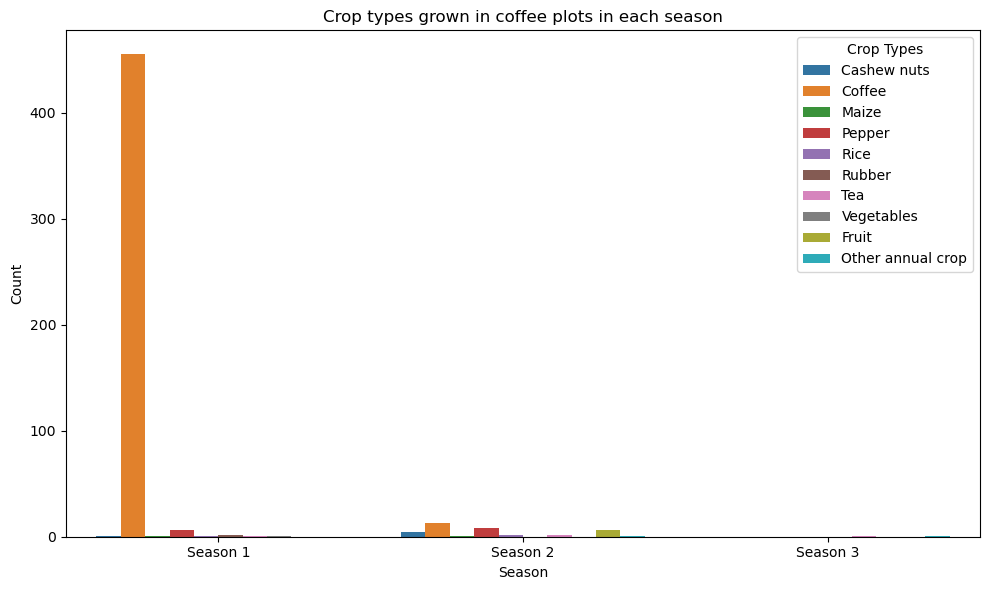

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# Melt the dataframe to long format
df_long = df_clean[['crop_1','crop_2','crop_3']].melt(value_name='crop', var_name='season')
# Replace season names
season_mapping = {'crop_1': 'Season 1', 'crop_2': 'Season 2', 'crop_3': 'Season 3'}
df_long['season'] = df_long['season'].replace(season_mapping)
# Count occurrences of each crop per season
counts = df_long.groupby(['season', 'crop']).size().reset_index(name='count')
# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='season', y='count', hue='crop')
plt.title('Crop types grown in coffee plots in each season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Crop Types')
plt.tight_layout()
plt.show()

#### All coffee plots only grow coffee for one season of the year (either season 1 or 2). Besides coffee, other crops that are often grown in coffee plots are pepper, rubber, and fruits => low level of diversification, crop rotation or intercropping. Farmers and households operating these plots are highly dependent on the fluctuation of coffee productivity and prices

<Axes: xlabel='Coffee_area_percent', ylabel='Count'>

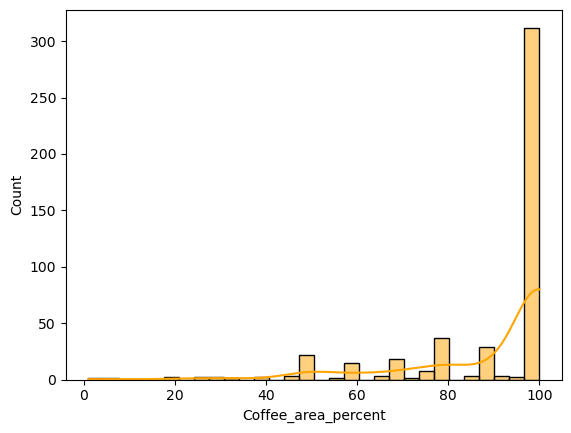

In [6]:
sns.histplot(df_clean,
             x='Coffee_area_percent', 
             bins=30, 
             kde=True, 
             color="orange", 
             edgecolor="black")

#### Most coffee plots (66%) use all of their areas for growing coffee 

<Axes: xlabel='Coffee_area', ylabel='Count'>

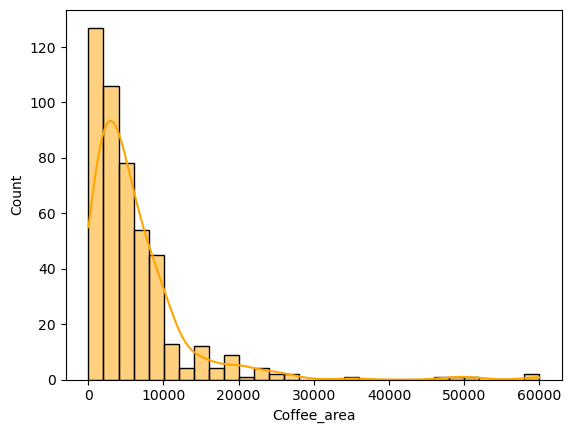

In [7]:
sns.histplot(df_clean,
             x='Coffee_area', 
             bins=30, 
             kde=True, 
             color="orange", 
             edgecolor="black") 

<Axes: xlabel='Coffee_productivity', ylabel='Count'>

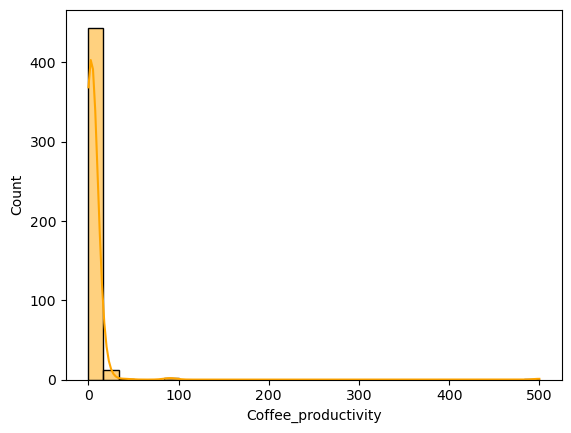

In [8]:
sns.histplot(df_clean,
             x='Coffee_productivity', 
             bins=30, 
             kde=True, 
             color="orange", 
             edgecolor="black")

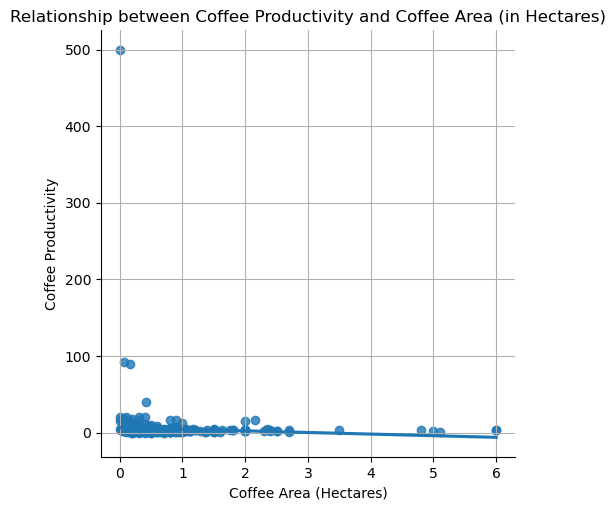

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_clean is your DataFrame
sns.lmplot(x='Coffee_area_hectare', y='Coffee_productivity', data=df_clean, ci=None)
plt.title('Relationship between Coffee Productivity and Coffee Area (in Hectares)')
plt.xlabel('Coffee Area (Hectares)')
plt.ylabel('Coffee Productivity')
plt.grid(True)
plt.show()

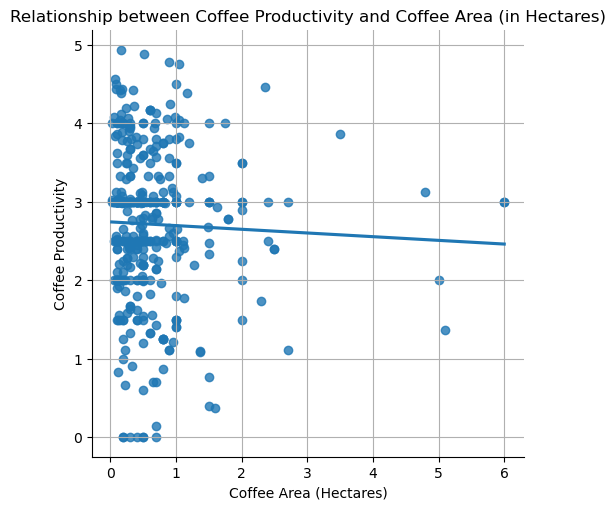

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

data=df_clean[df_clean.Coffee_productivity<5]
# Assuming df_clean is your DataFrame
sns.lmplot(x='Coffee_area_hectare', y='Coffee_productivity', data=data, ci=None)
plt.title('Relationship between Coffee Productivity and Coffee Area (in Hectares)')
plt.xlabel('Coffee Area (Hectares)')
plt.ylabel('Coffee Productivity')
plt.grid(True)
plt.show()


### Coffee productivity has a high degree of outliers and a negative relationship with coffee area. However, the relationship disappear when we remove the outliers. We also observe that productivity outliers often come from small plots. High degree of outliers focusing in small plots may suggest that these plot owners/operators do not record their data properly

C:\Users\USER\AppData\Local\Temp\ipykernel_5660\2330202554.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



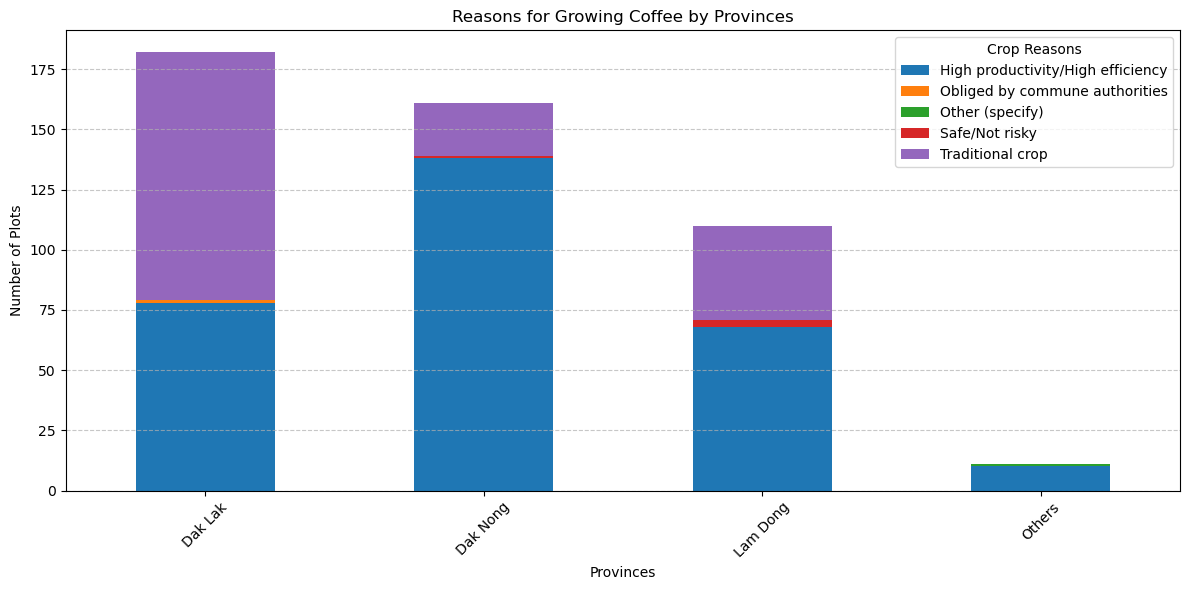

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate the data by provinces and reasons
reason_counts = df_clean.groupby(['tinh_2016_label', 'crop_reason_1']).size().unstack()

# Plot the data as a bar chart
reason_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Reasons for Growing Coffee by Provinces')
plt.xlabel('Provinces')
plt.ylabel('Number of Plots')
plt.legend(title='Crop Reasons', loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Two popular reasons for growing coffee: Traditional crop & High productivity/efficiency. For Dak Nong, Lam Dong, and other provinces, high productivity is the major reason. But for Dak Lak, trational crop is the major reason for growing coffee

C:\Users\USER\AppData\Local\Temp\ipykernel_5660\71095332.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



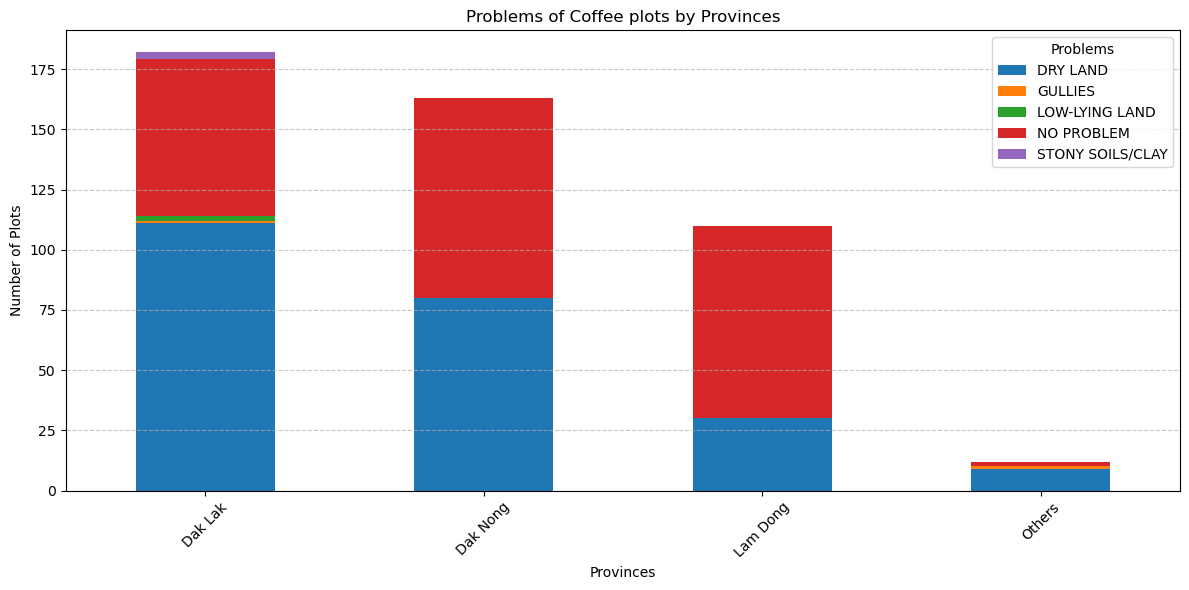

In [12]:
# Aggregate the data by provinces and reasons
problem_counts = df_clean.groupby(['tinh_2016_label', 'problems']).size().unstack()

# Plot the data as a bar chart
problem_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Problems of Coffee plots by Provinces')
plt.xlabel('Provinces')
plt.ylabel('Number of Plots')
plt.legend(title='Problems', loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Dry land is the main problem for coffee farming in Vietnam. The problem was concentrated in Dak Lak and Dak Nong. Besides dry land, Dak Lak also had other problems 

C:\Users\USER\AppData\Local\Temp\ipykernel_5660\2259998308.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



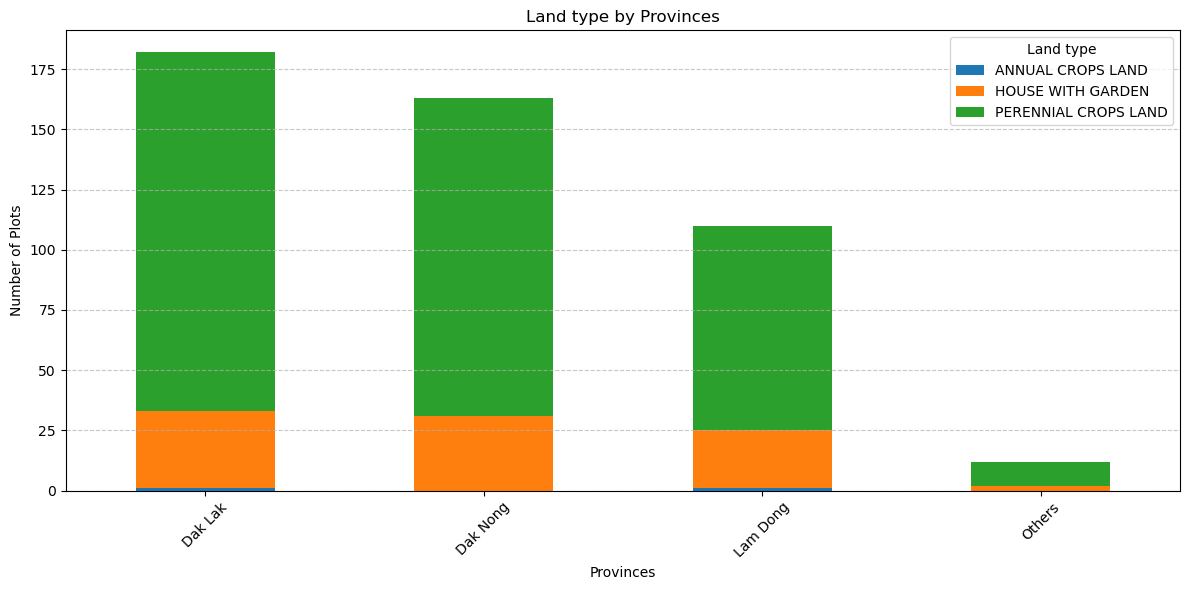

In [13]:
# Aggregate the data by provinces and reasons
landtype_counts = df_clean.groupby(['tinh_2016_label', 'land_type']).size().unstack()

# Plot the data as a bar chart
landtype_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Land type by Provinces')
plt.xlabel('Provinces')
plt.ylabel('Number of Plots')
plt.legend(title='Land type', loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Sustainable agricultural practices

## Soil and water conservation structures

In [14]:
df_clean.conservation_infrastructure_1.value_counts()

conservation_infrastructure_1
NONE                      417
OTHER                      20
BRICK WALL/FENCE           17
ROCK BUNDS                  9
SOIL BUNDS/GRASS LINES      4
Name: count, dtype: int64

In [15]:
df_clean['SWC_dummy']=~df_clean.conservation_infrastructure_1.isin(['NONE'])
df_clean['SWC_dummy'].value_counts()  

SWC_dummy
False    417
True      51
Name: count, dtype: int64

## Intercropping

#### Define intercropping: coffee plots that also grown other crops

In [16]:
df_clean['intercropping_dummy']=np.where((~df_clean.crop_1.isin(['Coffee','Left fallow','Not used',np.nan])) |
                                 (~df_clean.crop_2.isin(['Coffee','Left fallow','Not used',np.nan])) |
                                 (~df_clean.crop_3.isin(['Coffee','Left fallow','Not used',np.nan])), 
                                  True, False)
df_clean.intercropping_dummy.value_counts()

intercropping_dummy
False    431
True      37
Name: count, dtype: int64

## Organic fertilizer

In [17]:
df_clean['organic_fertilizer_dummy'] = (df_clean['organic_fertilizer'] > 0)
df_clean.organic_fertilizer_dummy.value_counts()


organic_fertilizer_dummy
True     293
False    175
Name: count, dtype: int64

## Leaving the land fallow

In [18]:
df_clean['fallow_dummy'] = (df_clean['fallow_owned_plot'] > 0)
df_clean.fallow_dummy.value_counts()

fallow_dummy
False    460
True       8
Name: count, dtype: int64

## SAPs adoption rates

In [19]:
# Generate SAPs_dummy column based on the specified conditions
df_clean['SAPs_dummy'] = df_clean[['SWC_dummy', 'intercropping_dummy', 'organic_fertilizer_dummy', 'fallow_dummy']].any(axis=1)
df_clean['SAPs_dummy'].value_counts()

SAPs_dummy
True     326
False    142
Name: count, dtype: int64

## How SAPs adoption correlated with other factors

### By provinces

C:\Users\USER\AppData\Local\Temp\ipykernel_5660\184413398.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



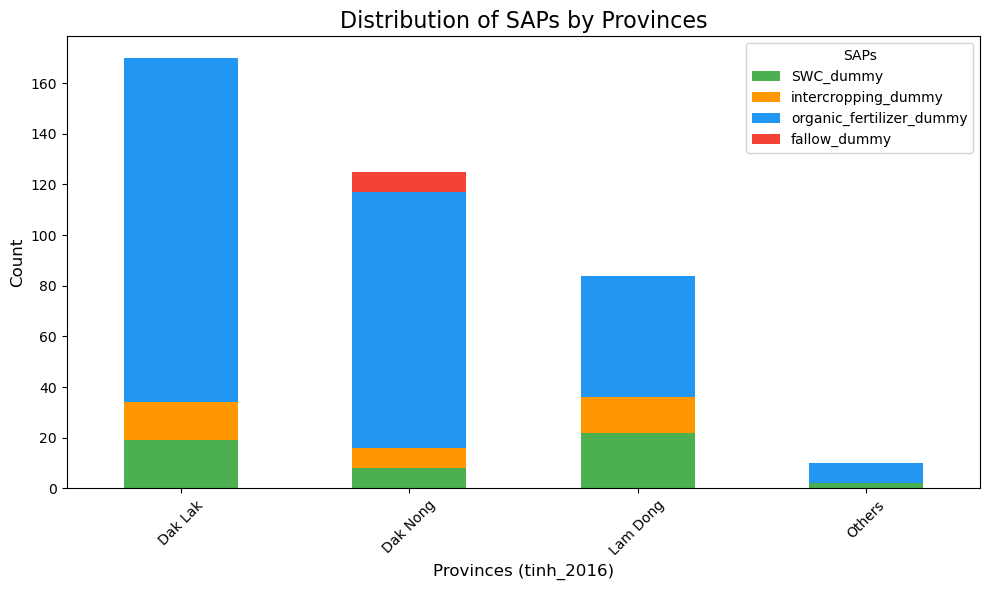

In [20]:
# Group data by 'tinh_2016' and sum up values for each column
province_distribution = df_clean.groupby('tinh_2016_label')[['SWC_dummy', 'intercropping_dummy', 'organic_fertilizer_dummy', 'fallow_dummy']].sum()

# Define custom colors for the columns
colors = ['#4caf50', '#ff9800', '#2196f3', '#f44336']  # Green, Orange, Blue, Red

# Plot a stacked bar chart with custom colors
ax = province_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Add labels and title
plt.title('Distribution of SAPs by Provinces', fontsize=16)
plt.xlabel('Provinces (tinh_2016)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='SAPs', labels=['SWC_dummy', 'intercropping_dummy', 'organic_fertilizer_dummy', 'fallow_dummy'])
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Overall, Dak Lak has the highest number of plots applying SAPs. Majority of plots applied organic fertilizer, focused in Dak Lak and Dak Nong. Lam Dong has more plots with soil and water conservation infrastructures compared with the other two provinces, it could happen because this province is more developed than others in the Central Highland. More plots in Lam Dong and Dak Lak grew coffee with other crops than in Dak Nong and other provinces

C:\Users\USER\AppData\Local\Temp\ipykernel_5660\2949575426.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



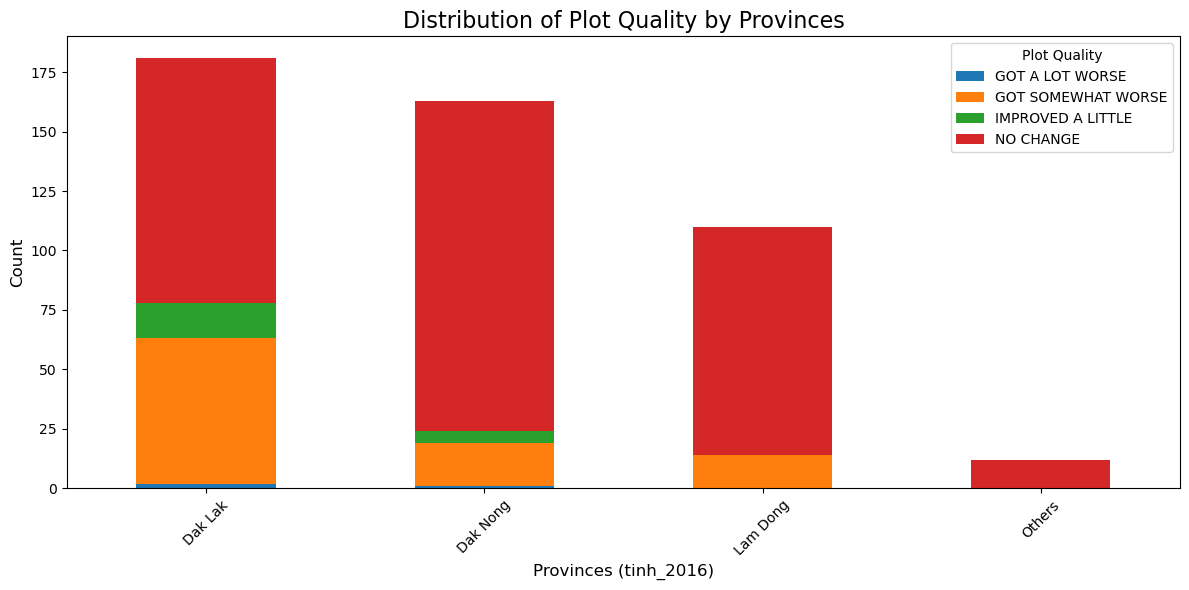

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the distribution of plot_quality for each province
plot_quality_distribution = df_clean.groupby(['tinh_2016_label', 'plot_quality_last_3_years']).size().unstack()

# Define custom colors for the four values of plot quality
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Plot the stacked bar chart with custom colors
plot_quality_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Add labels and title
plt.title('Distribution of Plot Quality by Provinces', fontsize=16)
plt.xlabel('Provinces (tinh_2016)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Plot Quality', labels=plot_quality_distribution.columns)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_5660\3448403181.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



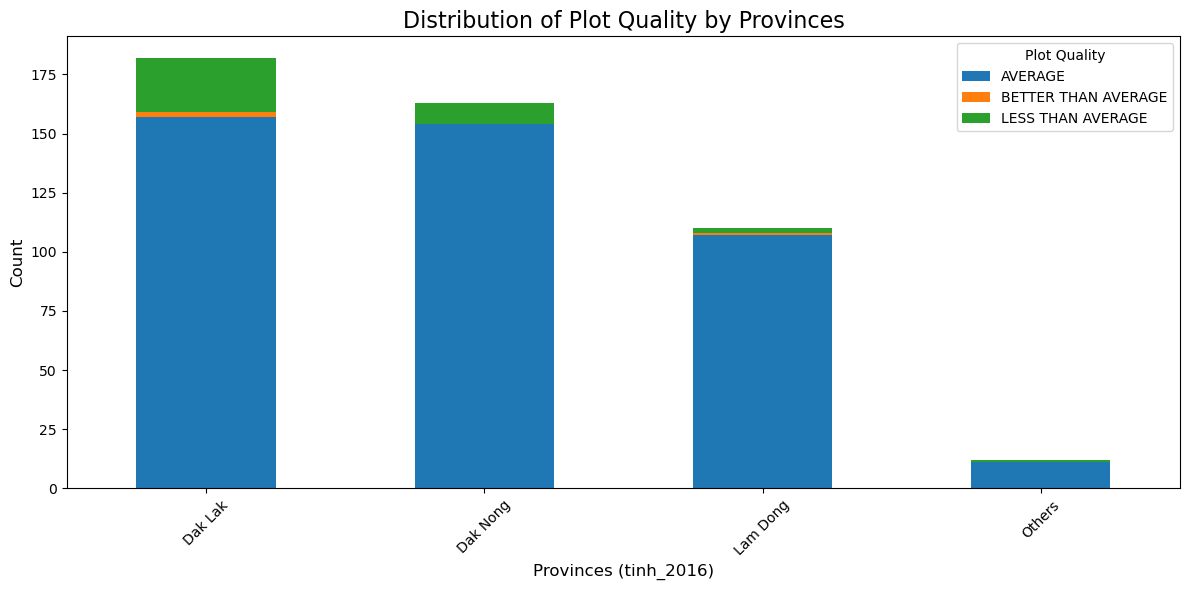

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the distribution of plot_quality for each province
plot_quality_distribution = df_clean.groupby(['tinh_2016_label', 'plot_quality_village']).size().unstack()

# Define custom colors for the four values of plot quality
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot the stacked bar chart with custom colors
plot_quality_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Add labels and title
plt.title('Distribution of Plot Quality by Provinces', fontsize=16)
plt.xlabel('Provinces (tinh_2016)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Plot Quality', labels=plot_quality_distribution.columns)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [47]:
%%stata -d df_clean
set showbaselevels all
foreach var in land_type slope problems plot_quality_village plot_quality_last_3_year irrigation water_source red_book obtain_mortgage natural_disaster ///
tinh_2016_label { 
eststo `var': logit SWC_dummy i.`var', or
}
foreach var in distance total_area Coffee_quantity_tonnes Coffee_area_hectare Coffee_productivity ///
{ 
eststo `var': logit SWC_dummy `var', or
}


  2. eststo `var': logit SWC_dummy i.`var', or
  3. }

note: 0.land_type != 0 predicts failure perfectly;
      0.land_type omitted and 2 obs not used.

note: 2.land_type omitted because of collinearity.
Iteration 0:   log likelihood = -158.71066  
Iteration 1:   log likelihood = -150.43035  
Iteration 2:   log likelihood = -147.97578  
Iteration 3:   log likelihood = -147.97288  
Iteration 4:   log likelihood = -147.97288  

Logistic regression                                     Number of obs =    465
                                                        LR chi2(1)    =  21.48
                                                        Prob > chi2   = 0.0000
Log likelihood = -147.97288                             Pseudo R2     = 0.0677

---------------------------------------------------------------------------------------
            SWC_dummy | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
----------------------+-----------------------------------------------------

In [58]:
%%stata -d df_clean
set showbaselevels all
foreach var in land_type slope problems plot_quality_village plot_quality_last_3_year irrigation water_source red_book obtain_mortgage natural_disaster ///
tinh_2016_label { 
eststo `var': reg Coffee_quantity_tonnes i.`var'
}
foreach var in distance total_area Coffee_area_hectare Coffee_productivity ///
{ 
eststo `var': reg Coffee_quantity_tonnes `var'
}


  2. eststo `var': reg Coffee_quantity_tonnes i.`var'
  3. }

      Source |       SS           df       MS      Number of obs   =       460
-------------+----------------------------------   F(2, 457)       =      6.37
       Model |  131.208549         2  65.6042745   Prob > F        =    0.0019
    Residual |  4706.12702       457  10.2978709   R-squared       =    0.0271
-------------+----------------------------------   Adj R-squared   =    0.0229
       Total |  4837.33557       459  10.5388575   Root MSE        =     3.209

---------------------------------------------------------------------------------------
Coffee_quantity_ton~s | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
----------------------+----------------------------------------------------------------
            land_type |
   ANNUAL CROPS LAND  |          0  (base)
   HOUSE WITH GARDEN  |  -7.369761   2.294767    -3.21   0.001    -11.87937   -2.860157
PERENNIAL CROPS LAND  |  -6.618378   2.2752

In [64]:
%%stata
reg Coffee_quantity_tonnes i.SWC_dummy
reg Coffee_quantity_tonnes i.SWC_dummy i.land_type ib("DUG WELL").water_source i.obtain_mortgage i.tinh_2016_label ///
Coffee_area_hectare 


      Source |       SS           df       MS      Number of obs   =       461
-------------+----------------------------------   F(1, 459)       =      4.32
       Model |  45.1106112         1  45.1106112   Prob > F        =    0.0383
    Residual |  4795.76426       459  10.4482881   R-squared       =    0.0093
-------------+----------------------------------   Adj R-squared   =    0.0072
       Total |  4840.87487       460   10.523641   Root MSE        =    3.2324

------------------------------------------------------------------------------
Coffee_qua~s | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   SWC_dummy |
          0  |          0  (base)
          1  |   1.005967   .4841357     2.08   0.038     .0545702    1.957365
             |
       _cons |   2.011633   .1594416    12.62   0.000     1.698307    2.324959
-----------------------------------------------------------------